# Data Science Capstone 3

## Image Classifier: Real vs AI

Objective is to create a model in the form of a neural network to be able to classify images as to being taken by a human (real) or generated by artificial intelligence (fake).
- Real images sources: Pexels, Unsplash, WikiArt
- Fake images sources: Stable Diffusion, MidJourney, DALL-E

## Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys

In [3]:
#!{sys.executable} -m pip install tensorflow

In [4]:
import tensorflow as tf

In [5]:
import os
import pickle

In [25]:
training_images_path = '../raw_data/train'
testing_images_path = '../raw_data/test'
ext = ['JPG', 'jpeg', 'png', 'jpg', 'gif', 'webp']

# Create a pandas dataframe
df = pd.DataFrame(columns = ['Filename','Dataset','Classification'])

def load_data(df, images_path, y):  
    # get all sub-classes (sub-directories)  
    subdirs = [s for s in os.listdir(images_path) if os.path.isdir(os.path.join(images_path,s))]
    
    for subdir in subdirs:
        path = os.path.join(images_path,subdir)
        print(path)
        with os.scandir(path) as files:
            for filename in files:
                f = os.path.join(path, filename.name)
                # checking if it is an image file
                if os.path.isfile(f) and f.split('.')[-1] in ext:
                    #print(f)
                    df.loc[len(df.index)] = [filename.name, y, subdir] 


load_data(df, training_images_path,'training')
load_data(df, testing_images_path, 'testing')

../raw_data/train\fake
../raw_data/train\real
../raw_data/test\fake
../raw_data/test\real


In [26]:
df.head(30)

,Filename,Dataset,Classification
0,0001.jpg,training,fake
1,0002.jpg,training,fake
2,0003.jpg,training,fake
3,0004.jpg,training,fake
4,0005.jpg,training,fake
5,0006.jpg,training,fake
6,0007.jpg,training,fake
7,0008.jpg,training,fake
8,0009.jpg,training,fake
9,0010.jpg,training,fake


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Filename        60000 non-null  object
 1   Dataset         60000 non-null  object
 2   Classification  60000 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


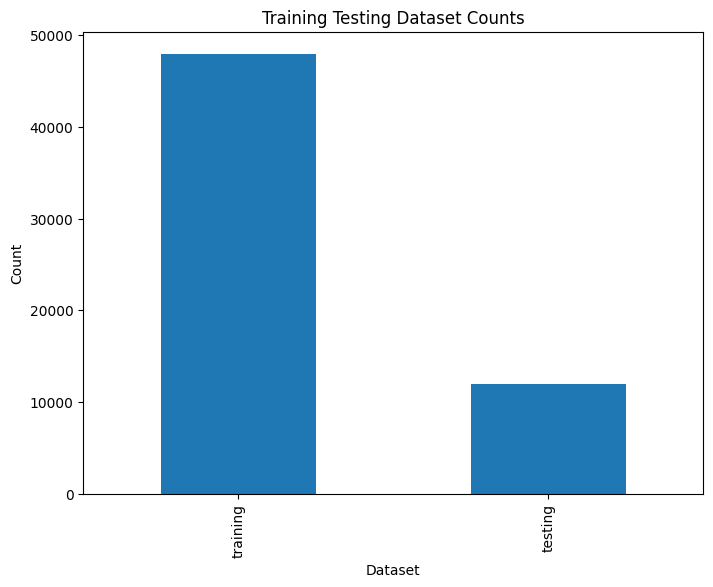

In [10]:
train_test_counts = df['Dataset'].value_counts()

plt.figure(figsize=(8,6))
train_test_counts.plot(kind='bar')
plt.title("Training Testing Dataset Counts")
plt.xlabel("Dataset")
plt.ylabel("Count")
plt.show()

In [11]:
train_test_counts

Dataset
training    48000
testing     12000
Name: count, dtype: int64

Due to the nature of the dataset, there are no null values nor any outliers, not possible with images.

## Exploratory Data Analysis

In [12]:
from PIL import Image, ImageOps, ImageFile

In [29]:
img = Image.open("../raw_data/train/real/0005.jpg")

print("Format:", img.format)         # e.g. JPEG, PNG
print("Mode:", img.mode)             # e.g. RGB, RGBA, L
print("Size:", img.size)             # (width, height)
print("Color channels:", len(img.getbands()))  # e.g. 3 for RGB

# File size in bytes
print("File size (bytes):", os.path.getsize("../raw_data/train/real/0005.jpg"))

Format: JPEG
Mode: RGB
Size: (4449, 3337)
Color channels: 3
File size (bytes): 1805075


In [30]:
img = Image.open("../raw_data/train/real/0009.jpg")

print("Format:", img.format)         # e.g. JPEG, PNG
print("Mode:", img.mode)             # e.g. RGB, RGBA, L
print("Size:", img.size)             # (width, height)
print("Color channels:", len(img.getbands()))  # e.g. 3 for RGB

# File size in bytes
print("File size (bytes):", os.path.getsize("../raw_data/train/real/0009.jpg"))

Format: JPEG
Mode: RGB
Size: (3872, 2581)
Color channels: 3
File size (bytes): 1498483


In [31]:
img = Image.open("../raw_data/train/real/0044.jpg")

print("Format:", img.format)         # e.g. JPEG, PNG
print("Mode:", img.mode)             # e.g. RGB, RGBA, L
print("Size:", img.size)             # (width, height)
print("Color channels:", len(img.getbands()))  # e.g. 3 for RGB

# File size in bytes
print("File size (bytes):", os.path.getsize("../raw_data/train/real/0044.jpg"))

Format: JPEG
Mode: RGB
Size: (3648, 5472)
Color channels: 3
File size (bytes): 1506569


In [17]:
# As shown above, the sizes of each image is far too large for memory
# Resize the images to be 128x128 with padding when necessary
ImageFile.LOAD_TRUNCATED_IMAGES = True

input_folders = ["../raw_data/train/fake", "../raw_data/train/real", "../raw_data/test/fake", "../raw_data/test/real"]
output_folders = ["modified_data/train/fake_128", "modified_data/train/real_128", "modified_data/test/fake_128", "modified_data/test/real_128"]
target_size = 128

for input_f, output_f in zip(input_folders, output_folders):
    print(input_f, output_f)

    os.makedirs(output_f, exist_ok=True)

    for filename in os.listdir(input_f):
        #Check to make sure it is an image file
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = Image.open(os.path.join(input_f, filename)).convert("RGB")

            # proportional resize
            img.thumbnail((target_size, target_size), Image.Resampling.LANCZOS)

            # add padding to make exact square
            img = ImageOps.pad(img, (target_size, target_size), color=(0, 0, 0))
            img.save(os.path.join(output_f, filename), quality=85, optimize=True)

../raw_data/train/fake modified_data/train/fake_128


C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


../raw_data/train/real modified_data/train/real_128


C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Pyt

../raw_data/test/fake modified_data/test/fake_128
../raw_data/test/real modified_data/test/real_128


C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (143040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (121554000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [32]:
img_128 = Image.open("modified_data/train/real_128/0005.jpg")

print("Format:", img_128.format)         # e.g. JPEG, PNG
print("Mode:", img_128.mode)             # e.g. RGB, RGBA, L
print("Size:", img_128.size)             # (width, height)
print("Color channels:", len(img_128.getbands()))  # e.g. 3 for RGB

# File size in bytes
print("File size (bytes):", os.path.getsize("modified_data/train/real_128/0005.jpg"))

Format: JPEG
Mode: RGB
Size: (128, 128)
Color channels: 3
File size (bytes): 2304


In [33]:
img_128 = Image.open("modified_data/train/real_128/0009.jpg")

print("Format:", img_128.format)         # e.g. JPEG, PNG
print("Mode:", img_128.mode)             # e.g. RGB, RGBA, L
print("Size:", img_128.size)             # (width, height)
print("Color channels:", len(img_128.getbands()))  # e.g. 3 for RGB

# File size in bytes
print("File size (bytes):", os.path.getsize("modified_data/train/real_128/0009.jpg"))

Format: JPEG
Mode: RGB
Size: (128, 128)
Color channels: 3
File size (bytes): 5687


In [34]:
img_128 = Image.open("modified_data/train/real_128/0044.jpg")

print("Format:", img_128.format)         # e.g. JPEG, PNG
print("Mode:", img_128.mode)             # e.g. RGB, RGBA, L
print("Size:", img_128.size)             # (width, height)
print("Color channels:", len(img_128.getbands()))  # e.g. 3 for RGB

# File size in bytes
print("File size (bytes):", os.path.getsize("modified_data/train/real_128/0044.jpg"))

Format: JPEG
Mode: RGB
Size: (128, 128)
Color channels: 3
File size (bytes): 3728


In [15]:
# Create an alternative sizing for existing neural networks
# Resize the images to be 224x224 with padding when necessary
ImageFile.LOAD_TRUNCATED_IMAGES = True

input_folders = ["../raw_data/train/fake", "../raw_data/train/real", "../raw_data/test/fake", "../raw_data/test/real"]
output_folders = ["modified_data/train/fake_224", "modified_data/train/real_224", "modified_data/test/fake_224", "modified_data/test/real_224"]
target_size = 224

for input_f, output_f in zip(input_folders, output_folders):
    print(input_f, output_f)

    os.makedirs(output_f, exist_ok=True)

    for filename in os.listdir(input_f):
        #Check to make sure it is an image file
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = Image.open(os.path.join(input_f, filename)).convert("RGB")

            # proportional resize
            img.thumbnail((target_size, target_size), Image.Resampling.LANCZOS)

            # add padding to make exact square
            img = ImageOps.pad(img, (target_size, target_size), color=(0, 0, 0))
            img.save(os.path.join(output_f, filename), quality=85, optimize=True)

raw_data/train/fake modified_data/train/fake_224


C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


raw_data/train/real modified_data/train/real_224


C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Pyt

raw_data/test/fake modified_data/test/fake_224
raw_data/test/real modified_data/test/real_224


C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (143040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (121554000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [28]:
img_224 = Image.open("modified_data/train/real_224/0005.jpg")

print("Format:", img_224.format)         # e.g. JPEG, PNG
print("Mode:", img_224.mode)             # e.g. RGB, RGBA, L
print("Size:", img_224.size)             # (width, height)
print("Color channels:", len(img_224.getbands()))  # e.g. 3 for RGB

# File size in bytes
print("File size (bytes):", os.path.getsize("modified_data/train/real_224/0005.jpg"))

Format: JPEG
Mode: RGB
Size: (224, 224)
Color channels: 3
File size (bytes): 5748


In [35]:
img_224 = Image.open("modified_data/train/real_224/0009.jpg")

print("Format:", img_224.format)         # e.g. JPEG, PNG
print("Mode:", img_224.mode)             # e.g. RGB, RGBA, L
print("Size:", img_224.size)             # (width, height)
print("Color channels:", len(img_224.getbands()))  # e.g. 3 for RGB

# File size in bytes
print("File size (bytes):", os.path.getsize("modified_data/train/real_224/0009.jpg"))

Format: JPEG
Mode: RGB
Size: (224, 224)
Color channels: 3
File size (bytes): 13986


In [36]:
img_224 = Image.open("modified_data/train/real_224/0044.jpg")

print("Format:", img_224.format)         # e.g. JPEG, PNG
print("Mode:", img_224.mode)             # e.g. RGB, RGBA, L
print("Size:", img_224.size)             # (width, height)
print("Color channels:", len(img_224.getbands()))  # e.g. 3 for RGB

# File size in bytes
print("File size (bytes):", os.path.getsize("modified_data/train/real_224/0044.jpg"))

Format: JPEG
Mode: RGB
Size: (224, 224)
Color channels: 3
File size (bytes): 9172


With the entire dataset of 60K images now compressed in both 128x128 and 224x224 versions, they are ready to be trained by a neural network.